In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['../'])

Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0] on linux


In [15]:
import numpy as np
from scripts.data_utils import load_data, get_random_split, get_connectome

from scripts.classification_models import LogRegPCA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import nibabel as nib
import nilearn
import pandas as pd
from collections import Counter
import nilearn.plotting as plotting

# Данные

Предлагаем два датасета: данные исследований Института мозга человека РАН (ИМЧ РАН) и открытый датасет Пекинского педагогического университета. Данные обоих датасетов представляют собой сканы функциональной МРТ (фМРТ) в двух состояниях - закрытые и открытые глаза.

Функциональная магнитно-резонансная томография (фМРТ) — это метод нейровизуализации, который позволяет исследовать активность мозга. В отличие от обычной МРТ, которая создает снимки структуры мозга, фМРТ фиксирует изменения, связанные с нейронной активностью.

### Как работает фМРТ:
Метод основывается на так называемом BOLD-сигнале (Blood Oxygen Level Dependent signal, сигнал зависящий от уровня оксигенации крови). Когда определенные участки мозга активны, они потребляют больше кислорода. Кровь с высоким и низким содержанием кислорода имеет разные магнитные свойства. Это различие и регистрируется с помощью фМРТ. В результате можно узнать, какие области мозга становятся активными в ответ на различные стимулы или задачи. Данные, получаемые на выходе - 3D изображения мозга, где каждому вокселю соответствует временной ряд, показывающий изменение уровня кислорода в крови с течением времени.

In [28]:
fmri_img_path = '/arch/OpenCloseProject/derivatives/sub-001/func/sub-001_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
fmri_img = nib.load(fmri_img_path)

# преобразование в numpy.array
img_array = fmri_img.get_fdata()

# первые три размерности - изображение, 
# четвертая - временной ряд, изменение изображения во времени
fmri_img.shape

(120, 142, 50, 120)

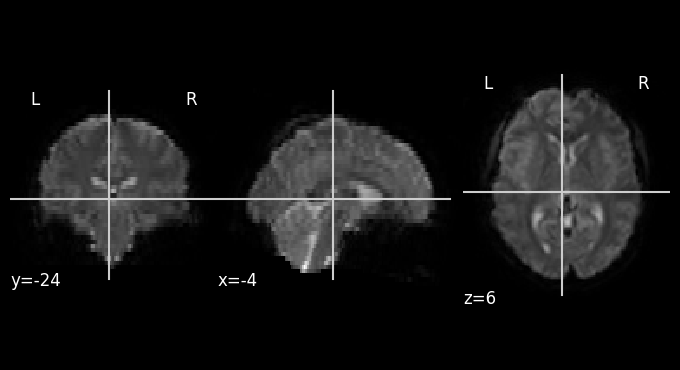

In [25]:
# визуализация фМРТ изображения на 40 временной точке
img_slice = fmri_img.slicer[:, :, :, 40]
nilearn.plotting.plot_img(img_slice, cmap='gray', black_bg=True);

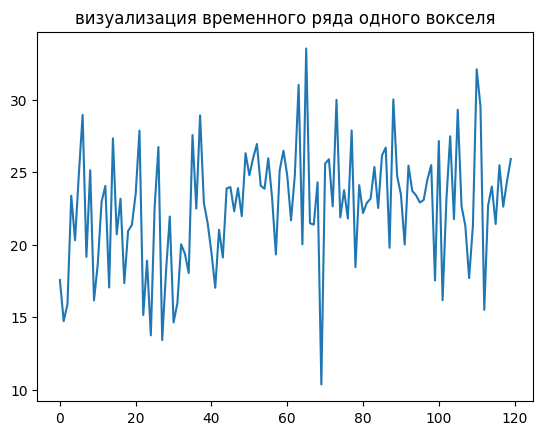

In [30]:
# теперь наоборот - визуализация временного ряда одного вокселя
plt.plot(img_array[30, 15, 22, :])
plt.title('визуализация временного ряда одного вокселя');

# Постановка задачи

фМРТ применяется в различных областях, включая медицину (планирование нейрохирургических операций, диагностика неврологических и психических расстройств, таких как эпилепсия, шизофрения и другие) и психофизиологию (изучение работы мозга в норме и при патологии, исследование психофизиологических процессов, таких как память, внимание, язык). 

Одной из основных задач в фМРТ исследованях является классификация состояний мозга человека на основе его функциональной активности, отраженной в BOLD-сигнале. фМРТ регистрируется в состоянии оперативного покоя и при выполнии различных видов целенаправленной активности (например, выполнение тестовых заданий), в норме и при различных патологических состояниях, в сознании и в состояних без сознания (сон, анестезия, кома). Особенно важной с клинической точки зрения является классификация патологических состояний мозга человека. Перспективным направлением в нейровизуализации является классификация состояний мозга с помощью методов машинного обучения. Для того, чтобы с уверенностью применять данные методы для классификации более сложных состояний (например, нормы и шизофрении, или различных подтипов шизофрении), необходимо отработать их работу на более простых примерах. 

Одним из базовых состояний мозга человека является состояние оперативного покоя с открытыми или закрытыми глазами. Различие между этими состояниями приемущественно затрагивает зрительные структуры мозга. В настоящем задании предлагается разработать эффективной подход к классификации состояний оперативного покоя с открытыми и закрытыми глазами с использованием методов машинного обучения и возможностью определения наиболее значимых для классификации признаков. Особенно важен этап интерпретации результатов работы моделей, чтобы для классификации они использовали не какие-то технические особенности изображений (например, шум), а реальные функциональные различия между состояниями мозга, которые могут быть обоснованы с нейрофизиологической точки зрения.

**Что нужно сделать**:
- Обучить модель
- Провести интерпретацию результатов обучения модели

Для обучения можно брать как один датасет, так и оба. Но в конечном итоге тест для ранжирования участников будет включать оба датасета одновременно. 

# Обработка данных

Из-за того, что размерность исходных фМРТ данных довольно велика (120 * 142 * 50 вокселей в нашем случае), принято уменьшать размерность используя, например, атласы мозга. С помощью атласов воксели объединяются в регионы, соответствующие структурам мозга, а временные серии усредняются по всем вокселям, включенным в регион. 

Здесь мы предлагаем использовать атлас [HCPex](https://github.com/wayalan/HCPex), в котором 426 регионов, включая 66 подкорковых.  

Таблица с информацией об атласе:

- **ID**: в таблице есть два столбца с ID. Разница между ними в сортировке. `HCPex_ID` сортирует строки в порядке, данном в файле атласа HCPex, то есть сначала указаны все регионы левого полушария (`Primary_Visual_Cortex_L` - L значит левое полушарие), потом правого. `SORTED_ID` сортирует строки в порядке *левый регион-правый регион* (`Primary_Visual_Cortex_L`, `Primary_Visual_Cortex_R`, ...)
- **Label**: название региона и короткая форма названия
- **Cortical division**: к какой структуре мозга относится регион
- **X, Y, Z**: координаты центроида региона
- **Functional network**: к какой функциональной сети относится регион, на основе статей авторов [Cole и Anticevic](https://github.com/ColeLab/ColeAnticevicNetPartition)

In [3]:
hcp_table = pd.read_excel('/home/tm/projects/OpenCloseBaseline/HCPex_Atlas_Description.xlsx', 
                          index_col='HCPex_ID').sort_index()
hcp_table.head()

,NEW_ID,Label,Short_label,Cortical Division,Cortical_Division_Number,X,Y,Z,ColeAnticevic_functional_network,ColeAnticevic_functional_network_label
HCPex_ID,,,,,,,,,,
1,1,Primary_Visual_Cortex_L,L_V1,Primary_Visual,1,-10.078,-84.159,1.759,1,Visual1
2,3,Second_Visual_Area_L,L_V2,Early_Visual,2,-12.044,-82.059,4.029,2,Visual2
3,5,Third_Visual_Area_L,L_V3,Early_Visual,2,-16.607,-84.793,7.259,2,Visual2
4,7,Fourth_Visual_Area_L,L_V4,Early_Visual,2,-29.556,-86.009,-1.542,2,Visual2
5,9,IntraParietal_Sulcus_Area_1_L,L_IPS1,Dorsal_Stream_Visual,3,-24.456,-74.776,38.047,2,Visual2


**Функциональные сети**

Функциональные сети мозга формируются благодаря взаимодействию различных участков мозга, которые координируются в состоянии покоя и при выполнения конкретных когнитивных задач. Эти сети состоят из областей мозга, которые синхронно активируются и работают вместе для достижения общей цели, такой как восприятие, внимание, память или моторное управление. Функциональные сети формируются за счет синхронизации активности между различными областями мозга. Эта синхронизация может измеряться с помощью таких методов, как электроэнцефалография (ЭЭГ) или фМРТ. Часто синхронизация происходит на определенных частотах (например, альфа-ритм, бета-ритм и т.д.), что помогает различным областям мозга работать слаженно.
В мозге выделяют несколько ключевых функциональных сетей, каждая из которых отвечает за выполнение определенных функций. Например:
- Сеть пассивного режима работы (Default Mode Network, DMN) активируется, когда человек находится в состоянии покоя, размышляет или вспоминает.
- Сеть внимания (Attention Network) активируется при выполнении задач, требующих концентрации и фокусировки.
- Моторные и сенсорные сети (Somatomotor network) ответственны за контроль движений и обработку соматосенсорной информации.
- Зрительные сети (Visual Networks) отвечают за обработку зрительной информации.

In [45]:
hcp_table.ColeAnticevic_functional_network_label.value_counts()

ColeAnticevic_functional_network_label
Default                 77
Cingulo-Opercular       56
Visual2                 54
Frontoparietal          50
Thalamus                42
Somatomotor             39
Subcortical             24
Language                23
Dorsal-Attention        23
Auditory                15
Posterior-Multimodal     7
Visual1                  6
Orbito-Affective         6
Ventral-Multimodal       4
Name: count, dtype: int64

# Бейзлайн

Наиболее распространенный вариант работы с фМРТ данными в области машинного обучения -- использовать векторизованные матрицы связности (connectivity matrix) в качестве обучающих данных.

Матрицы функциональной связности показывают схожесть временных рядов двух регионов. Обычно выражается в коэффициенте корреляции. Идея в том, что если два региона работают вместе, то их сигналы будут похожи.

На вход модели подают матрицу, превращенную в длинный вектор.

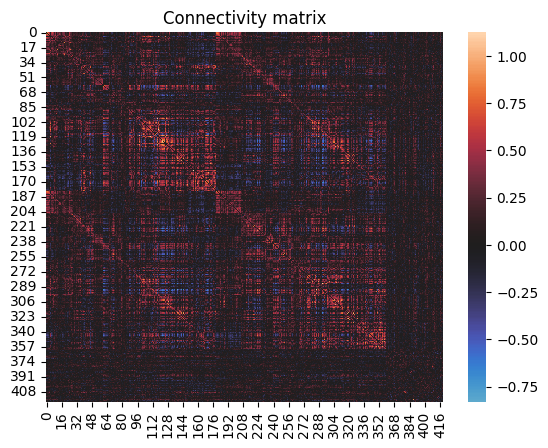

In [4]:
path_to_dataset = "/data/Projects/OpenCloseIHB/ihb_dataset.hdf5"
X, _, _ = load_data(path_to_dataset)

# функция для вычисления матриц связности
cm = get_connectome(X)

# нарисуем матрицу связности для первого человека
sns.heatmap(cm[0], center=0)
plt.title('Connectivity matrix');

## Датасет ИМЧ РАН

Данные ИМЧ РАН представляют собой сканы функционального МРТ в двух состояниях (закрытые и открытые глаза) для 84 человек (т.е. всего 168 сессий в датасете).

HDF5 файл состоит из 84 папок для каждого испытуемого. Внутри папок два массива -- для закрытых и открытых глаз, каждый размерности `(120, 420)`, где 120 - количество временных точек (сканов), а 420 - количество регионов интереса. В данных количество регионов меньше, чем в атласе, из-за падения BOLD-сигнала в областях мозга около черепных пазух вследствие высокой неоднородности магнитного поля (регионы `365, 372, 396, 398, 401, 405` по индексу `HCPex_ID`)

In [5]:
path_to_ihb_dataset = "/data/Projects/OpenCloseIHB/ihb_dataset.hdf5"

# единичный сплит
X_ihb, y_ihb, groups_ihb = load_data(path_to_ihb_dataset)
X_train_ihb, X_test_ihb, y_train_ihb, y_test_ihb, _, _ = get_random_split(X_ihb, y_ihb, groups_ihb, 
                                                                          test_size=0.15, 
                                                                          random_state=6)

In [6]:
logreg_ihb = LogRegPCA()
logreg_ihb.model.set_params(**{'C': 0.0002})
logreg_ihb.pca.set_params(**{'n_components': 0.80})


train_acc = logreg_ihb.model_training(X_train_ihb, y_train_ihb)
conf_mat, acc = logreg_ihb.model_testing(X_test_ihb, y_test_ihb)

Accuracy on train: 0.894
Accuracy on test: 0.731


### Интерпретация

Здесь для понимания работы модели мы ищем коэффициенты, вносящие наибольший вклад в предсказание. Далее соотносим эти коэффициенты с регионами интереса.

In [7]:
# удаляем из таблицы атласа регионы, которых нет в наших данных
del_cols = [365, 372, 396, 398, 401, 405]
hcp_table.drop(del_cols, axis=0, inplace=True)

In [8]:
# 
coefs_ihb = logreg_ihb.pca.inverse_transform(logreg_ihb.model.coef_)
df_ihb = pd.DataFrame(np.abs(coefs_ihb).reshape(420, 420), 
                  index=hcp_table['Label'].values, 
                  columns=hcp_table['Label'].values)

df_ihb.head()

,Primary_Visual_Cortex_L,Second_Visual_Area_L,Third_Visual_Area_L,Fourth_Visual_Area_L,IntraParietal_Sulcus_Area_1_L,Area_V3A_L,Area_V3B_L,Sixth_Visual_Area_L,Area_V6A_L,Seventh_Visual_Area_L,...,Nucleus_Accumbens_R,Globus_pallidus_externalis_R,Globus_pallidus_internalis_R,Amygdala_R,Substantia_nigra_pars_compacta_R,Substantia_nigra_pars_reticulata_R,Ventral_tegmenta_area_R,Mammillary_bodies_R,Septal_nucleus_R,Nuclei_basal_R
Primary_Visual_Cortex_L,9.228229e-18,0.741873,0.614671,0.482553,0.294074,0.456868,0.346476,0.456975,0.256915,0.351158,...,0.018245,0.073529,0.049508,0.096048,0.040044,0.031212,0.018648,0.006994,0.067134,0.036594
Second_Visual_Area_L,7.418732e-01,0.000000,0.794144,0.587610,0.339882,0.616582,0.421367,0.558260,0.315030,0.453629,...,0.012191,0.077759,0.033701,0.125818,0.019831,0.034258,0.013034,0.021816,0.009679,0.040115
Third_Visual_Area_L,6.146715e-01,0.794144,0.000000,0.693481,0.373072,0.747039,0.459612,0.519052,0.389115,0.549988,...,0.017257,0.069715,0.042872,0.140061,0.018571,0.016131,0.016270,0.000309,0.019458,0.050746
Fourth_Visual_Area_L,4.825533e-01,0.587610,0.693481,0.000000,0.374300,0.543250,0.512815,0.363648,0.301589,0.490769,...,0.001087,0.043869,0.014940,0.103903,0.006974,0.000800,0.003177,0.016578,0.040267,0.044968
IntraParietal_Sulcus_Area_1_L,2.940738e-01,0.339882,0.373072,0.374300,0.000000,0.343971,0.399415,0.340923,0.425571,0.487183,...,0.000250,0.073376,0.023062,0.087809,0.007088,0.008734,0.010044,0.014164,0.016116,0.028899


0.7362657633834364


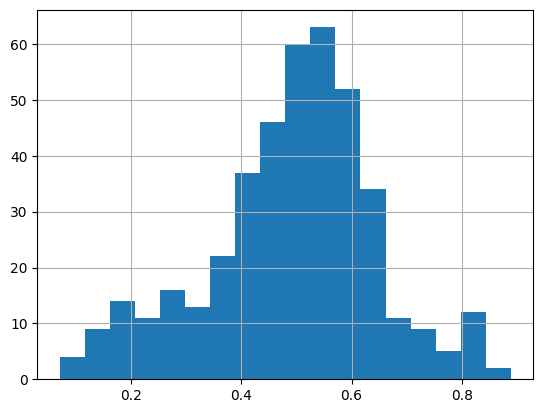

In [9]:
# для выбора порога, относительно которого мы будем считать связь регионов значительной,
# нарисуем распределение максимальных значений корреляции
df_ihb.max().hist(bins='auto');
print(np.percentile(df_ihb.max(), q=95))

In [10]:
# выбрали порог
important_rois_ihb = df_ihb.values > 0.79

# так как матрица симметричная, можно убрать парные значения
rows_ihb, cols_ihb = np.nonzero(np.tril(important_rois_ihb))

# связи между этими регионами считаем важными для модели
edge_names = list(zip(hcp_table.iloc[rows_ihb].Label, hcp_table.iloc[cols_ihb].Label))
edge_names

[('Third_Visual_Area_L', 'Second_Visual_Area_L'),
 ('Primary_Visual_Cortex_R', 'Primary_Visual_Cortex_L'),
 ('Second_Visual_Area_R', 'Second_Visual_Area_L'),
 ('Third_Visual_Area_R', 'Third_Visual_Area_L'),
 ('Third_Visual_Area_R', 'Second_Visual_Area_R'),
 ('Primary_Motor_Cortex_R', 'Primary_Motor_Cortex_L'),
 ('Area_7m_R', 'Area_7m_L'),
 ('Parieto-Occipital_Sulcus_Area_1_R', 'Parieto-Occipital_Sulcus_Area_1_L'),
 ('Parieto-Occipital_Sulcus_Area_2_R', 'Parieto-Occipital_Sulcus_Area_2_L')]

In [11]:
# для создания новой симметричной матрицы с только важными регионами 
# объединим списки с индексами 
important_idx_ihb = list(set(rows_ihb).union(set(cols_ihb)))

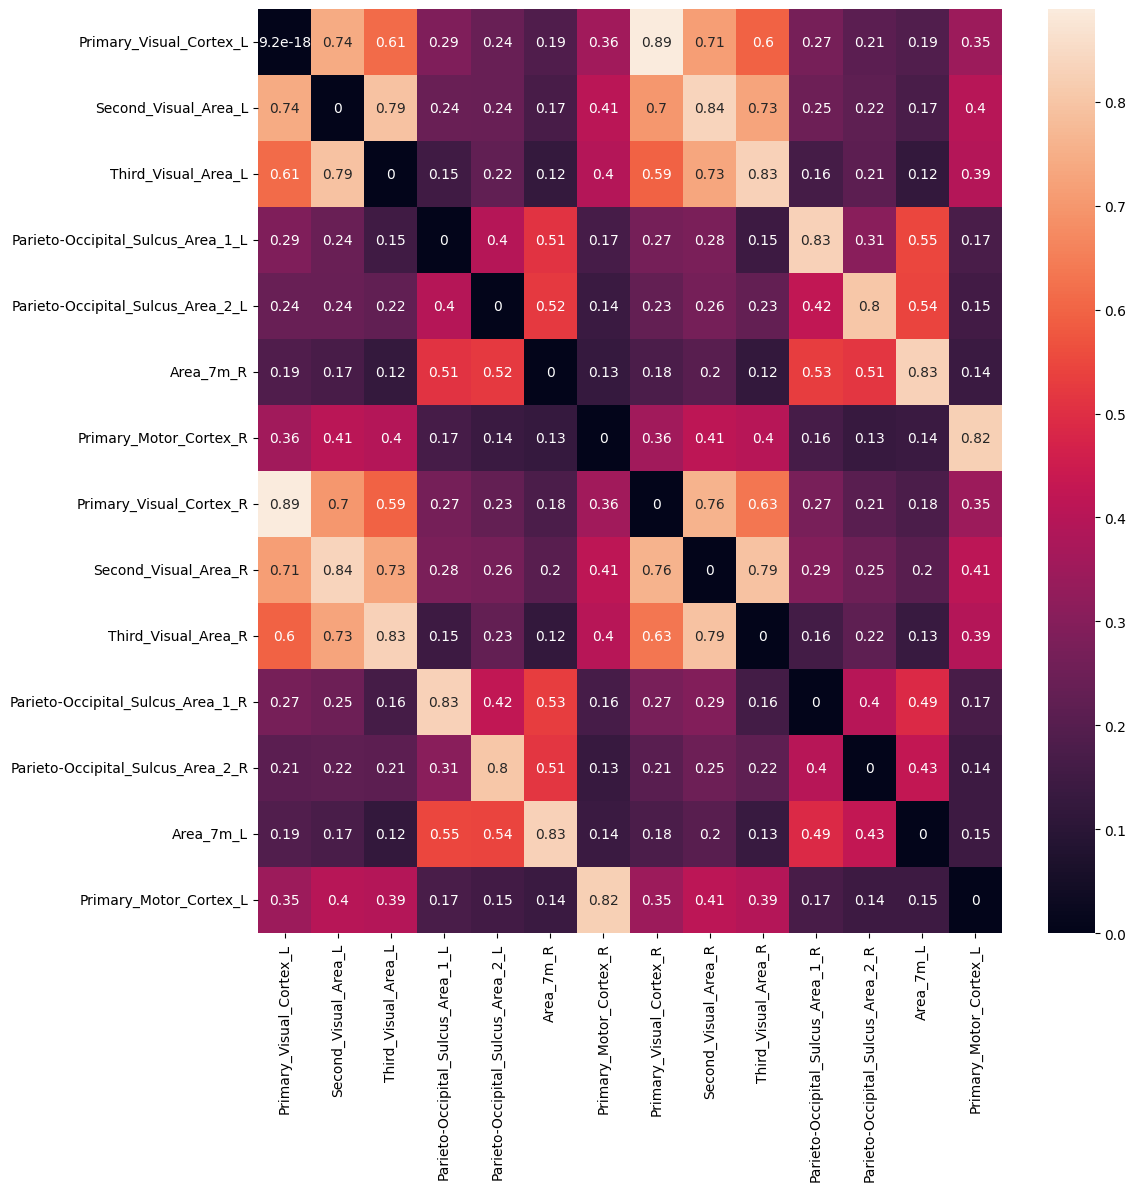

In [13]:
# матрица коэффициентов модели с только важными регионами
plt.figure(figsize=(12, 12))
sns.heatmap(df_ihb.values[important_idx_ihb, :][:, important_idx_ihb], 
            xticklabels=hcp_table.iloc[important_idx_ihb].Label, 
            yticklabels=hcp_table.iloc[important_idx_ihb].Label, 
            annot=True);

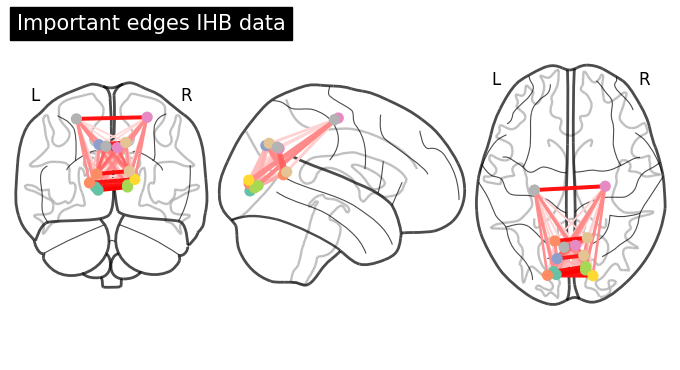

In [21]:
# если мы возьмем матрицу выше в качестве матрицы смежности 
# для построения графа, который покажет наиболее активированные области

plotting.plot_connectome(df_ihb.values[important_idx_ihb, :][:, important_idx_ihb], 
                         hcp_table.iloc[important_idx_ihb][['X', 'Y', 'Z']],
                         title='Important edges IHB data');

In [22]:
# найденные вершины соответсвуют таким функциональным сетям
Counter(hcp_table.iloc[important_idx_ihb]['ColeAnticevic_functional_network_label'])

Counter({'Visual2': 4,
         'Default': 4,
         'Visual1': 2,
         'Frontoparietal': 2,
         'Somatomotor': 2})

## Датасет Пекин

Датасет Пекинского университета состоит из двух сканов в состоянии закрытых глаз и одного скана с открытыми глазами для 48 испытуемых. HDF5 файл состоит из 48 папок для каждого испытуемого. 

Папки названы в соответствии с id испытуемого. Далее внутри папок испытуемых лежат 3 массива. В этом датасете 3 скана: 2 для закрытых и 1 для открытых. При этом  у всех людей первая сессия -- закрытые глаза, а остальные сессии разнятся (то есть 2 сессия может быть тоже при закрытых глазах, 3 - при открытых). Это указано в названии. 

Особенность датасета - для двух людей удалены по одному скану из-за плохого качества данных (для sub-3258811 закрытые глаза, 3 сессия, и для sub-2021733 открытые глаза, 2 сессия).

In [187]:
path_to_dataset_china = "/data/Projects/OpenCloseChina/china_dataset.hdf5"

# единичный сплит
X_china, y_china, groups_china = load_data(path_to_dataset_china)
X_train_china, X_test_china, y_train_china, y_test_china, _, _ = get_random_split(X_china, y_china, groups_china, 
                                                                                  test_size=0.15, random_state=6)

In [188]:
logreg_china = LogRegPCA()
logreg_china.model.set_params(**{'C': 0.0002})
logreg_china.pca.set_params(**{'n_components': 0.8})

train_acc = logreg_china.model_training(X_train_china, y_train_china)
conf_mat, acc = logreg_china.model_testing(X_test_china, y_test_china)

Accuracy on train: 0.771
Accuracy on test: 0.792


### Интерпретация

In [190]:
coefs_china = logreg_china.pca.inverse_transform(logreg_china.model.coef_)
df_china = pd.DataFrame(np.abs(coefs_china).reshape(420, 420), 
                  index=hcp_table['Label'].values, 
                  columns=hcp_table['Label'].values)

df_china.head()

,Primary_Visual_Cortex_L,Second_Visual_Area_L,Third_Visual_Area_L,Fourth_Visual_Area_L,IntraParietal_Sulcus_Area_1_L,Area_V3A_L,Area_V3B_L,Sixth_Visual_Area_L,Area_V6A_L,Seventh_Visual_Area_L,...,Nucleus_Accumbens_R,Globus_pallidus_externalis_R,Globus_pallidus_internalis_R,Amygdala_R,Substantia_nigra_pars_compacta_R,Substantia_nigra_pars_reticulata_R,Ventral_tegmenta_area_R,Mammillary_bodies_R,Septal_nucleus_R,Nuclei_basal_R
Primary_Visual_Cortex_L,4.103202e-18,0.910310,0.758920,0.548963,0.296179,0.524242,0.349104,0.414706,0.310677,0.386579,...,0.090485,0.057030,0.029879,0.092827,0.039528,0.028813,0.003844,0.0,0.066256,0.089610
Second_Visual_Area_L,9.103096e-01,0.000000,1.039304,0.707245,0.339371,0.733093,0.440458,0.583088,0.396491,0.499461,...,0.106693,0.052746,0.024197,0.108928,0.035648,0.002888,0.005037,0.0,0.055670,0.074398
Third_Visual_Area_L,7.589199e-01,1.039304,0.000000,0.814458,0.356721,0.846247,0.480836,0.548231,0.425779,0.559018,...,0.095460,0.033957,0.019817,0.096835,0.024997,0.004657,0.002808,0.0,0.037246,0.064945
Fourth_Visual_Area_L,5.489631e-01,0.707245,0.814458,0.000000,0.393156,0.623973,0.560518,0.360187,0.337349,0.525399,...,0.080409,0.032058,0.011660,0.109106,0.030405,0.006009,0.001329,0.0,0.038558,0.055249
IntraParietal_Sulcus_Area_1_L,2.961789e-01,0.339371,0.356721,0.393156,0.000000,0.347380,0.450669,0.313680,0.420493,0.515787,...,0.061680,0.027497,0.005250,0.077265,0.021763,0.008952,0.007286,0.0,0.035122,0.025581


0.9190385771148811


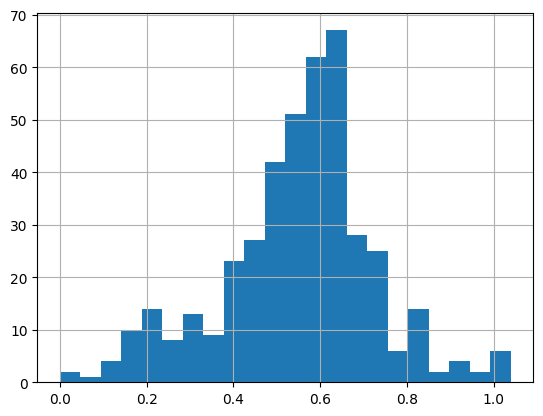

In [191]:
df_china.max().hist(bins='auto');
print(np.percentile(df_china.max(), q=98))

In [192]:
important_rois_china = df_china.values > 0.85

rows_china, cols_china = np.nonzero(np.tril(important_rois_china))
edge_names = list(zip(hcp_table.iloc[rows_china].Label, hcp_table.iloc[cols_china].Label))
edge_names

[('Second_Visual_Area_L', 'Primary_Visual_Cortex_L'),
 ('Third_Visual_Area_L', 'Second_Visual_Area_L'),
 ('Primary_Visual_Cortex_R', 'Primary_Visual_Cortex_L'),
 ('Second_Visual_Area_R', 'Second_Visual_Area_L'),
 ('Second_Visual_Area_R', 'Third_Visual_Area_L'),
 ('Second_Visual_Area_R', 'Primary_Visual_Cortex_R'),
 ('Third_Visual_Area_R', 'Second_Visual_Area_L'),
 ('Third_Visual_Area_R', 'Third_Visual_Area_L'),
 ('Third_Visual_Area_R', 'Second_Visual_Area_R'),
 ('Primary_Motor_Cortex_R', 'Primary_Motor_Cortex_L'),
 ('Parieto-Occipital_Sulcus_Area_1_R', 'Parieto-Occipital_Sulcus_Area_1_L'),
 ('Parieto-Occipital_Sulcus_Area_2_R', 'Parieto-Occipital_Sulcus_Area_2_L'),
 ('Putamen_R', 'Putamen_L')]

In [193]:
important_idx_china = list(set(rows_china).union(set(cols_china)))
hcp_table.iloc[important_idx_china].Label

HCPex_ID
1                Primary_Visual_Cortex_L
2                   Second_Visual_Area_L
3                    Third_Visual_Area_L
129    Parieto-Occipital_Sulcus_Area_1_L
130    Parieto-Occipital_Sulcus_Area_2_L
415                            Putamen_R
211               Primary_Motor_Cortex_R
181              Primary_Visual_Cortex_R
182                 Second_Visual_Area_R
183                  Third_Visual_Area_R
309    Parieto-Occipital_Sulcus_Area_1_R
310    Parieto-Occipital_Sulcus_Area_2_R
382                            Putamen_L
31                Primary_Motor_Cortex_L
Name: Label, dtype: object

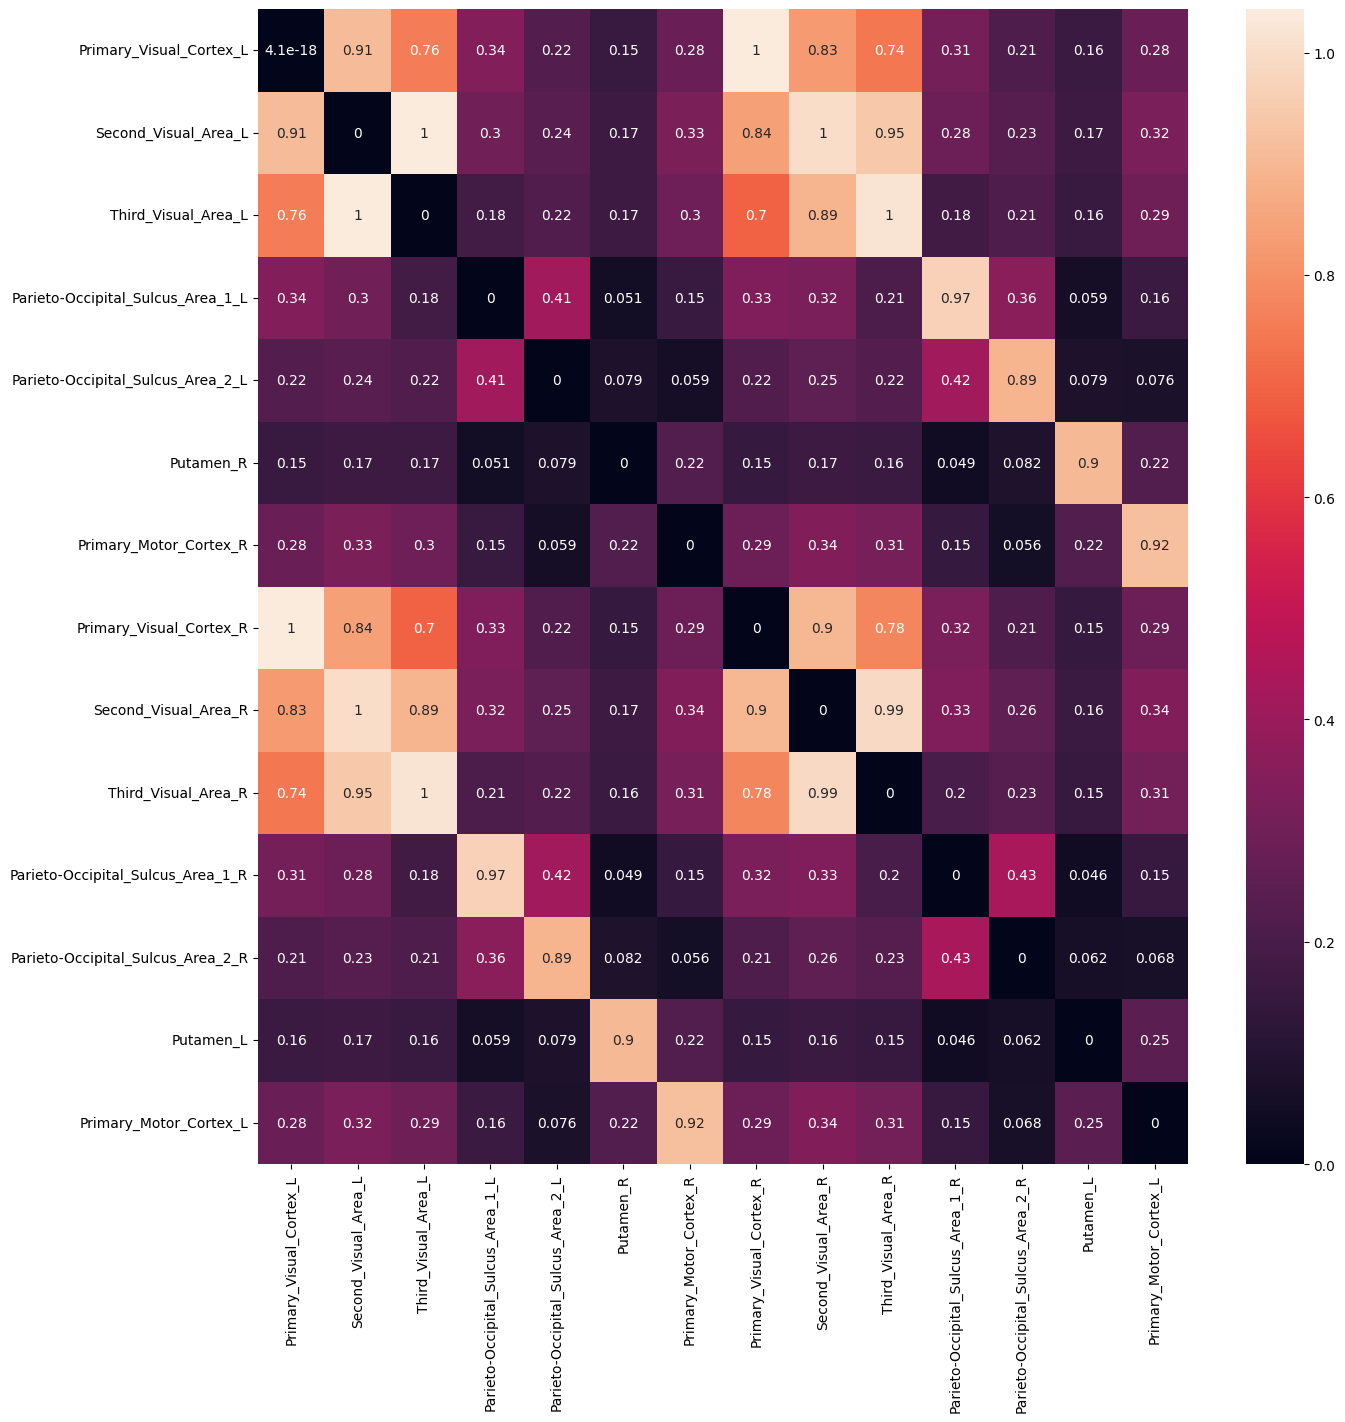

In [194]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_china.values[important_idx_china, :][:, important_idx_china], 
            xticklabels=hcp_table.iloc[important_idx_china].Label, 
            yticklabels=hcp_table.iloc[important_idx_china].Label, 
            annot=True);

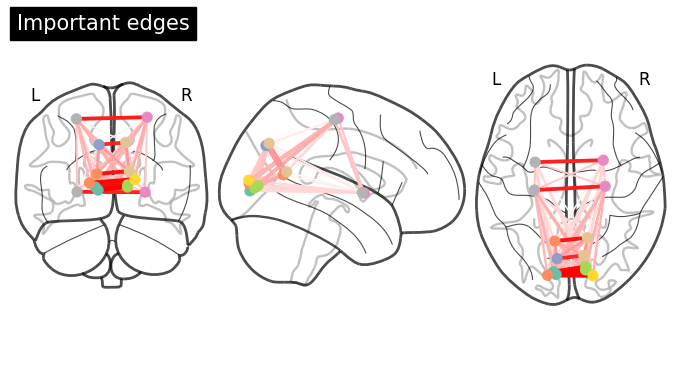

In [195]:
nilearn.plotting.plot_connectome(df_china.values[important_idx_china, :][:, important_idx_china], 
                                 hcp_table.iloc[important_idx_china][['X', 'Y', 'Z']],
                                 title='Important edges');

In [196]:
Counter(hcp_table.iloc[important_idx_china]['ColeAnticevic_functional_network_label'])

Counter({'Visual2': 4,
         'Visual1': 2,
         'Default': 2,
         'Frontoparietal': 2,
         'Subcortical': 2,
         'Somatomotor': 2})